In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
from torch import Tensor

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(device)

cuda


In [4]:
imsize = 512 if torch.cuda.is_available() else 128
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [5]:
# I used this images. You can download them and use in your sample data
# content image: https://drive.google.com/file/d/1ktGSBvj0E_Hd9kB9vIIy128u3H0i71Sr/view?usp=sharing
# style image: https://drive.google.com/file/d/16Wppd13lD839TAriUJ95ku9tbLwbcE99/view?usp=sharing

style_image = image_loader("/content/sample_data/images/Van_Gogh.jpg")
content_image = image_loader("/content/sample_data/images/Tuebingen_Neckarfront.jpg")

In [6]:
unloader = transforms.ToPILImage()
plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

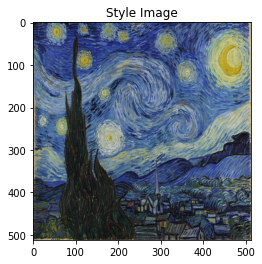

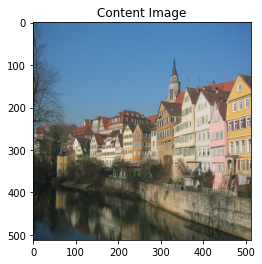

In [7]:
plt.figure()
imshow(style_image, title='Style Image')
plt.figure()
imshow(content_image, title='Content Image')

In [8]:
class ContentLoss(nn.Module):

    def __init__(self, target: Tensor):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input: Tensor):
        self.loss = F.mse_loss(input, self.target)
        return input

In [9]:
def gram_matrix(input: Tensor):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

In [10]:
class StyleLoss(nn.Module):

    def __init__(self, target: Tensor):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target).detach()

    def forward(self, input: Tensor):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [11]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [12]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean: Tensor, std: Tensor):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, image: Tensor):
        return (image - self.mean) / self.std

In [13]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_image, content_image, content_layers=content_layers_default,
                               style_layers=style_layers_default):

    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    must = len(content_layers) + len(style_layers)
    for layer in cnn.children():
        if must == 0:
            break
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'max_pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'batch_norm_{}'.format(i)
        else:
            raise RuntimeError('Unexpected layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_image).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
            must -= 1

        if name in style_layers:
            target = model(style_image).detach()
            style_loss = StyleLoss(target)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
            must -= 1

    return model, style_losses, content_losses

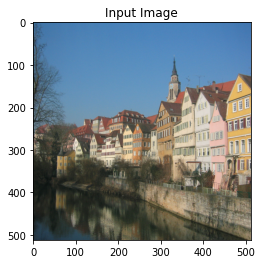

In [14]:
input_image = content_image.clone()
# input_image = torch.randn(content_image.data.size(), device=device)
plt.figure()
imshow(input_image, title='Input Image')

In [15]:
def calculate_loss(style_losses, content_losses, style_weight, content_weight, print_flag=False):
    style_score = 0
    content_score = 0
    for style_loss in style_losses:
        style_score += style_loss.loss
    for content_loss in content_losses:
        content_score += content_loss.loss
    style_score *= style_weight
    content_score *= content_weight
    if print_flag:
        print('Style Loss : {:4f} Content Loss: {:4f}'.format(
            style_score.item(), content_score.item()))
        print()
    return style_score + content_score

In [16]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_image, style_image, input_image, num_steps=300,
                       style_weight=1000000, content_weight=1):

    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_image, content_image)
    
    input_image.requires_grad_(True)
    model.requires_grad_(False)
    optimizer = optim.LBFGS([input_image])

    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_image.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_image)

            run[0] += 1
            print_flag = False
            if run[0] % 100 == 0:
                print("run {}:".format(run))
                print_flag = True

            loss = calculate_loss(style_losses, content_losses, style_weight, content_weight, print_flag)
            loss.backward()
            return loss

        optimizer.step(closure)

    with torch.no_grad():
        input_image.clamp_(0, 1)

    return input_image

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [100]:
Style Loss : 30.338655 Content Loss: 29.840210

run [200]:
Style Loss : 6.387502 Content Loss: 20.050865

run [300]:
Style Loss : 3.309717 Content Loss: 14.965966

run [400]:
Style Loss : 1.941679 Content Loss: 12.525904

run [500]:
Style Loss : 1.298275 Content Loss: 11.152224

run [600]:
Style Loss : 1.042910 Content Loss: 10.283369

run [700]:
Style Loss : 0.910881 Content Loss: 9.768412

run [800]:
Style Loss : 0.826299 Content Loss: 9.451870

run [900]:
Style Loss : 0.774187 Content Loss: 9.238396

run [1000]:
Style Loss : 0.729801 Content Loss: 9.104136



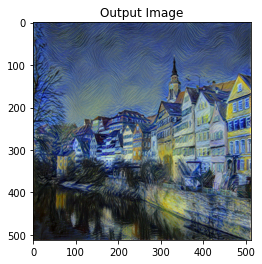

In [17]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_image, style_image, input_image, num_steps=1000)

plt.figure()
imshow(output, title='Output Image')
plt.ioff()
plt.show()